# Разработка A/B-тестирования и анализ результатов для развлекательного приложения

Автор: Столярова Оксана

Дата: 04.04.2025

## Описание данных

A/B-тестирование  необходимо провести для компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Задача - рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

Для работы даны три таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


##  Цель и задачи проекта:
рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

<a id=intro></a>
### Содержание проекта

1. [Работа с историческими данными (EDA)](#1)
2. [Подготовка к тесту](#2)
3. [Мониторинг А/В-теста](#3)
4. [Проверка результатов A/B-теста](#4)
5. [Вывод по результатам A/B-эксперимента](#5)
---

<a id='1'></a>
### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе работаем с историческими данными приложения:

- Импортируем библиотеку pandas.

- Считываем и сохраняем в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy.stats import ttest_ind

In [2]:
# Выгружаем данные из датасета sessions_project_history.csv в датафрейм sessions_history
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

In [3]:
# Выводим первые строки датафрейма на экран
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


На первый взгляд данные корректны и соответсвуют названиям столбцов

#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного из пользователей с наибольшим количеством сессий. Ес

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.

In [4]:
#рассчитаем количество уникальных сессий для каждого пользователя и отсортируем значения по убыванию 
sessions_by_users = sessions_history.groupby('user_id')['session_id'].nunique().sort_values(ascending=False)
sessions_by_users

user_id
10E0DEFC1ABDBBE0    10
6A73CB5566BB494D    10
8A60431A825D035B     9
D11541BAC141FB94     9
5BCFE7C4DCC148E9     9
                    ..
1DF13BB1953B3497     1
628502A3CE7E0A3C     1
1DEEF40DEFBD0C65     1
AC08479B7472C628     1
8A0882B6715D9EE5     1
Name: session_id, Length: 134039, dtype: int64

Максимальное количество сессий для пользователя по исследуемым данным равно 10.

In [5]:
#Выбираем  пользователя с максимальным количеством сессий
max_sessions_user = sessions_by_users.idxmax()
max_sessions_user

'10E0DEFC1ABDBBE0'

In [6]:
#Выводим таблицу для пользователя с максимальным количеством сессий 
sessions_history[sessions_history['user_id']==max_sessions_user]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Будем считать, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразим их на одном графике.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [7]:
#Рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения
all_users_by_days = sessions_history.groupby('session_date')['user_id'].nunique().reset_index()
reg_users_by_days = sessions_history[sessions_history['registration_flag']==1].groupby('session_date')['user_id'].nunique().reset_index()

#Объединяем данные в одну таблицу
unique_users_count = all_users_by_days.merge(reg_users_by_days, on='session_date', how='inner')

#Даем понятные названия стобцам таблицы
unique_users_count.columns=['session_date', 'all_users', 'registered_users']
unique_users_count.head()

,session_date,all_users,registered_users
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840


Теперь построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням.

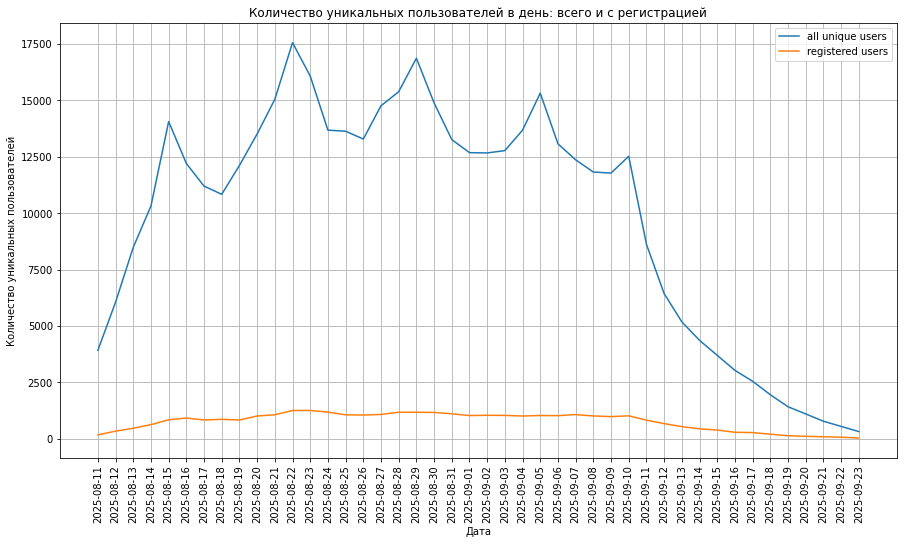

In [9]:
#Задаем значения по осям
x = unique_users_count.session_date
y_all = unique_users_count.all_users
y_reg = unique_users_count.registered_users

#Строим график для количества уникальтных пользователей:зарегистрированных и всего
plt.figure(figsize=(15, 8))
plt.plot(x, y_all, label ='all unique users')
plt.plot(x, y_reg,label ='registered users')

plt.xlabel("Дата")
plt.ylabel("Количество уникальных пользователей")
plt.legend()
plt.title('Количество уникальных пользователей в день: всего и с регистрацией')
plt.xticks(rotation=90)
plt.grid()
plt.show()

По графику видно, что общее количество уникальных пользователей значительно превышает количество зарегистрированных пользователей, причем количество зарегистрированных - более постоянная величина, общее количество довольно сильно колеблется по дням, всплески посещений наблюдаются по пятницам. К концу рассматриваемого периода наблюдается снижение количества пользователей в день. Возможно это связано с началом учебного времени (сентябрь), если предположить, что основной целевой аудиторией приложения являются школьники и студенты.

Следующим шагом посчитаем доли зарегистрированных пользователей от всех пользователей по дням и построим отдельный линейный график. 

In [10]:
#Посчитаем доли зарегистрированных пользователей от всех пользователей по дням
unique_users_count['reg_share'] = round(unique_users_count['registered_users']/unique_users_count['all_users'], 3)
unique_users_count.head()

,session_date,all_users,registered_users,reg_share
0,2025-08-11,3919,169,0.043
1,2025-08-12,6056,336,0.055
2,2025-08-13,8489,464,0.055
3,2025-08-14,10321,625,0.061
4,2025-08-15,14065,840,0.060


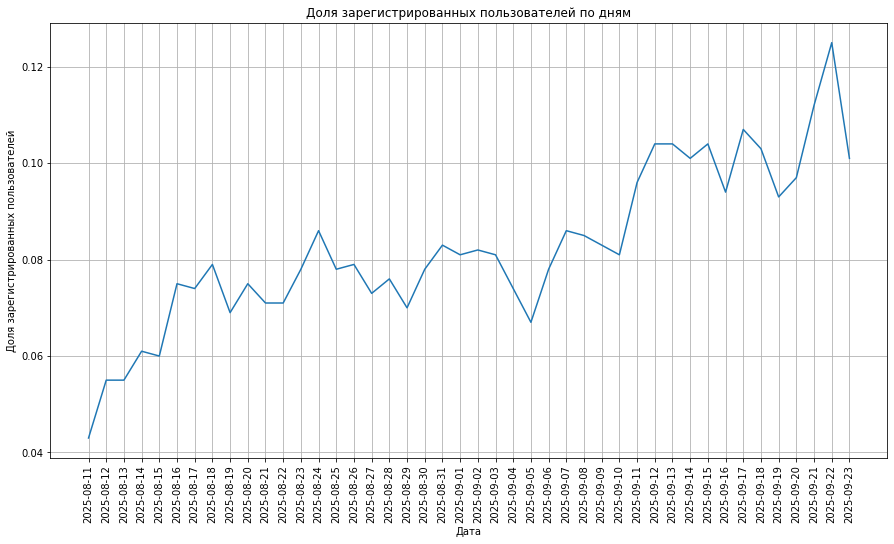

In [11]:
#Строим график для доли зарегистрированных пользователей 

x = unique_users_count.session_date
y = unique_users_count.reg_share

plt.figure(figsize=(15, 8))
plt.plot(x, y)

plt.xlabel("Дата")
plt.ylabel("Доля зарегистрированных пользователей")
plt.title('Доля зарегистрированных пользователей по дням')
plt.xticks(rotation=90)
plt.grid()
plt.show()

По графику видно , что доля зарегистрированных пользователей ежедневно колеблется, но в целом можно отметить ее значительный рост за расматриваемый период. С 4% в начале наблюдения она достигла максимума более 12% 22 сентября. Рост доли зарегистрированных пользователей в целом является хорошим показателем для приложения. Однако в сочетании с падением общего количества пользователей в сентябре, этот вопрос требует дальнейшего изучения.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц.

- Построим столбчатую диаграмму с числом просмотренных страниц и количество сессий.

In [12]:
#Находим количество сессий для каждого значения числа просмотренных страниц
session_by_page = sessions_history.groupby('page_counter')['session_id'].count().reset_index()
session_by_page

,page_counter,session_id
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


По данным датасета пользователи просматривают от 1 до 7 страниц за сессию. Однако, наиболее типичное количество страниц за сессию находится в диапозоне от 2 до 4. Построим для наглядности стобчатую диаграмму.

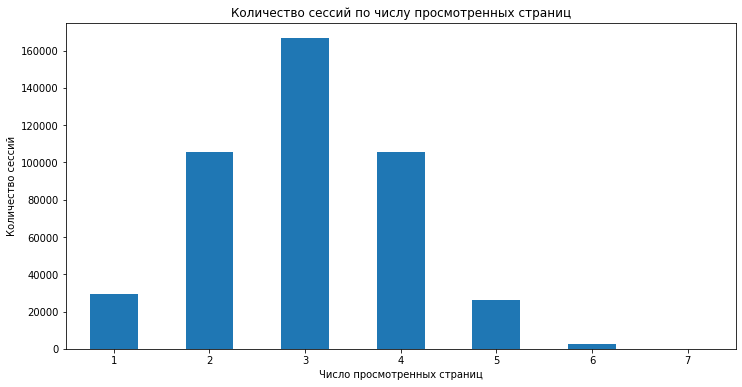

In [13]:
#строим стобчатую диаграмму для визуализации количества сессий по числу просмотренных страниц
session_by_page.plot(kind='bar', x='page_counter', y='session_id', legend=False, figsize=(12, 6))
plt.title('Количество сессий по числу просмотренных страниц')
plt.ylabel('Количество сессий')
plt.xlabel('Число просмотренных страниц')
plt.xticks(rotation=0)
plt.show()

График наглядно демонстрирует, что чаще всего пользователи просматривают по 3 страницы за сессию, 6-7 страниц - крайне редкие случаи, более 7 страниц не было просмотрено ни разу за рассматриваемый период. При этом, чем больше страниц будет просматриваться за сессию, тем больше заинтересованность пользователя в контенте и выше вероятность подписки.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [14]:
#создадим новый столбец 'good_session' в датафрейме sessions_history с помощью пользовательской функции create_good
#определяем функцию, которая создаст новый столбец с бинарным признаком в зависимости от наличия данных в другом столбце
def create_good(x):
    if x >= 4:
        return 1
    return 0

# Создаем новый столбец 'good_session' на основе данных в столбце'page_counter':
sessions_history['good_session'] = (sessions_history['page_counter'].apply(create_good))

# Проверяем результат
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


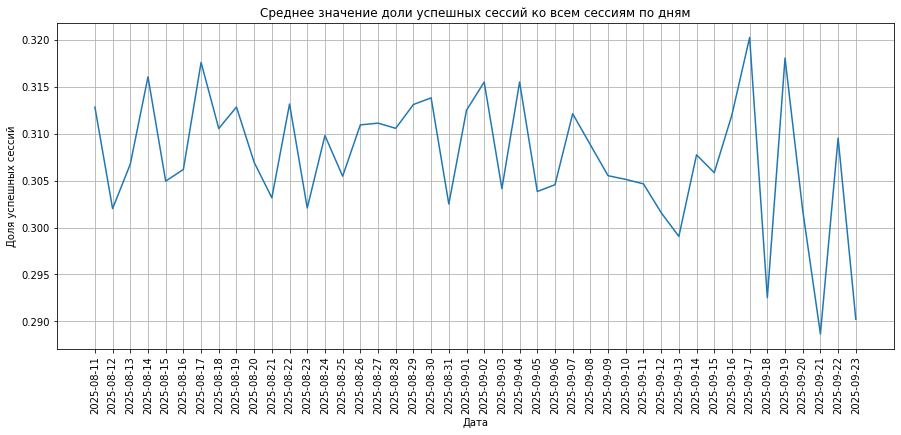

In [15]:
#рассчитаем долю "хороших" сессий за каждый день
good_session_share = sessions_history.groupby('session_date')['good_session'].mean()

#создаем линейный график на основе полученных данных
plt.figure(figsize=(15, 6))
good_session_share.plot.line()
plt.title('Cреднее значение доли успешных сессий ко всем сессиям по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.xticks(ticks=range(len(good_session_share)), labels=good_session_share.index, rotation=90)
plt.grid()
plt.show()

По графику видно, что доля "хороших" сессий в день колеблется, но до 11 сентября она стабильно находилась в диапозоне от 30% до 32%, а после этой даты колебания стали более значительными и в целом рассматриваемый показатель начал снижаться. Опять же это может быть связано как с началом учебного процесса, так и со снижением интерса к приложению.

[*К содержанию*](#intro) 

<a id='2'></a>
### 2. Подготовка к тесту

#### 2.1. Расчёт размера выборки

Для рассчета размера выборки возьмем следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Минимальный детектируемый эффект, или MDE, — 3%.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [16]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2 # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста.

In [17]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = int(all_users_by_days.mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size/avg_daily_users*2)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дней


[*К содержанию*](#intro) 

<a id='3'></a>
### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

По условиям задания A/B-тест успешно запущен, и доступны данные за первые три дня. Нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считааем и сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитааем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитааем и выведем на экран процентную разницу в количестве пользователей в группах A и B, постороим соответсвующую визуализацию.

In [18]:
# Выгружаем данные из датасета sessions_project_test_part.csv в датафрейм sessions_test_part
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')

sessions_test_part.head()    

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


По первым строкам, можно судить, что данные на первый взгляд корректны и сопоставимы с ранее рассмтреными историческими данными по структуре.

In [19]:
#Рассчитаtv количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения
import numpy as np
metrics = sessions_test_part.set_index('test_group').groupby('test_group').agg({'user_id': 'nunique'}).T
metrics 

test_group,A,B
user_id,1477,1466


Размеры групп сопоставимы и составляют 1477 и 1466 уникальных пользователей в группах А и В соответсвенно. Для более точной оценки рассчитаем процентную разницу.

In [20]:
#Рассчитаем процентную разницу в количестве пользователей в группах A и B 
P = 100*abs(metrics['A']-metrics['B'])/metrics['A']
P

user_id    0.744753
dtype: float64

Процентная разница в количестве пользователей в группах A и B составляет менее 1%, что вполне допустимо для проведения тестирования.

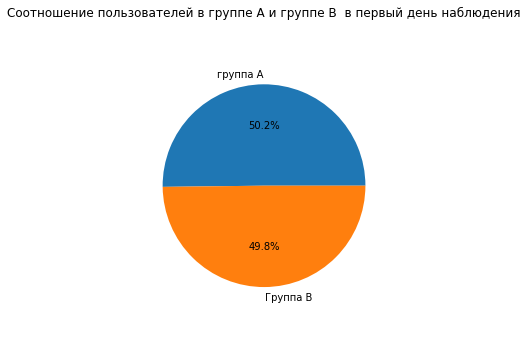

In [21]:
# Построим круговую диаграмму на основе соотношения уикальных пользователей в эспериментальных группах
unique_users = sessions_test_part.groupby(['user_id', 'test_group'])['session_id'].count().reset_index()
plt.figure(figsize=(4, 6))  
plt.pie(unique_users['test_group'].value_counts(normalize=True),
        labels=['группа А', 'Группа B'],
        autopct='%1.1f%%')

plt.axis('equal') 

# Заголовок
plt.title('Соотношение пользователей в группе A и группе B  в первый день наблюдения')

# Показываем график
plt.show()

Круговая диаграмма наглядно опказывает, что пользователи в тестируемых группах распределены практически равномерно.

#### 3.2. Проверка пересечений пользователей
Убедимся в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

In [22]:
#Проверим встречаются ли одновременно одни и те же пользователи в группах A и B
users_a = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
users_b = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = list(set(users_a) & set(users_b))
print(intersection) 

[]


Пересечений по пользователям в группах A и B нет, значит наши группы соответсвуют условию независимости.

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

In [23]:
# Создадим сводную таблицу с распределением пользователей по типам используемых устройств
pivot_device = sessions_test_part.pivot_table(
    columns='test_group',
    index='device',
    aggfunc={'user_id': 'nunique'},
)
display(pivot_device)

user_id     
test_group       A    B
device                 
Android        656  668
Mac            156  148
PC             369  381
iPhone         296  269

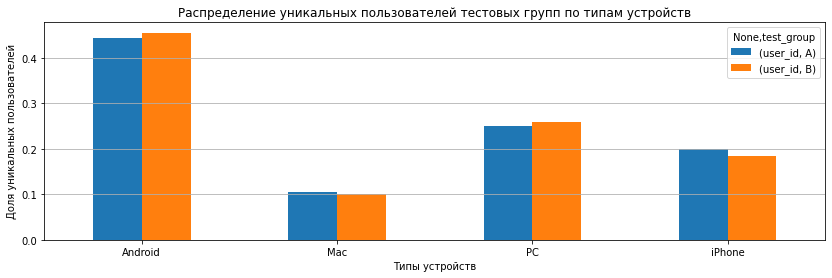

In [24]:
#Нормализуем данные
pivot_device_normalized = pivot_device.div(pivot_device.sum(axis=0), axis=1)

# Построим график столбчатой диаграммы с выводом долей
pivot_device_normalized.plot(kind='bar',
                  title='Распределение уникальных пользователей тестовых групп по типам устройств',
                  legend=True,
                  ylabel='Доля уникальных пользователей',
                  xlabel='Типы устройств',
                  rot = 0,     
                  figsize=(14, 4))
plt.grid(axis='y')
    
# Выводим график
plt.show()

По графику видно,что пользователи распределлены по категориям используемых устройств примерно равномерно, значимой разницы не наблюдается ни по одной из категорий.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

In [25]:
# Создадим сводную таблицу с распределением пользователей по регионам
pivot_region = sessions_test_part.pivot_table(
    columns='test_group',
    index='region',
    aggfunc={'user_id': 'nunique'},
)
display(pivot_region)

user_id     
test_group       A    B
region                 
CIS            644  645
EU             224  217
MENA           609  604

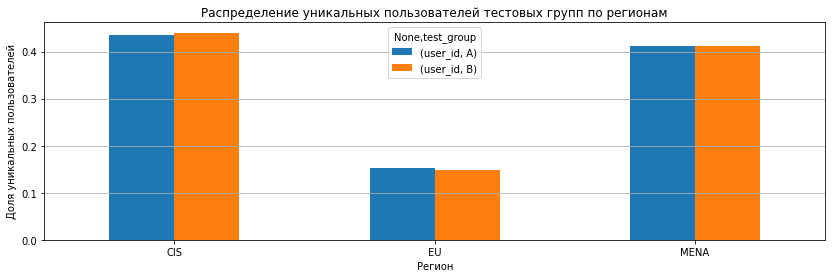

In [26]:
#Нормализуем данные
pivot_region_normalized = pivot_region.div(pivot_region.sum(axis=0), axis=1)

# Построим график столбчатой диаграммы с выводом долей
pivot_region_normalized.plot(kind='bar',
                  title='Распределение уникальных пользователей тестовых групп по регионам',
                  legend=True,
                  ylabel='Доля уникальных пользователей',
                  xlabel='Регион',
                  rot = 0,     
                  figsize=(14, 4))
plt.grid(axis='y')
    
# Выводим график
plt.show()

По графику видно,что пользователи распределлены по регионам равномерно, значимой разницы не наблюдается.

#### 3.5. Вывод после проверки A/B-теста

На основе проверки данных по первому дню тестирования можно сделать следующие выводы:

    - количество уникальных пользователей в группах А и В практически одинаково и различается менее, чем на 1%,
    - выбоки независимы, в них нет пересечений по пользователям,
    - пользователи тестовой и контрольной групп равномерно распределены  по категориальным переменным: устройствам и регионам.
    
Таким образом, пользователи в тестовой и контрольной группах распределены рамномерны и выборки независимы, а значит A/B-тест проходит корректно.

[*К содержанию*](#intro) 

<a id='4'></a>
### 4. Проверка результатов A/B-теста

Теперь будем работать с результатами за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считаем и сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [27]:
# Выгружаем данные из датасета sessions_project_test.csv в датафрейм sessions_test
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

# Выводим первые строки датафрейма на экран
display(sessions_test.head())    
display(sessions_test.info())  

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
dtypes: int64(3), object(8)
memory usage: 8.4+ MB


None

Данные заполнено корректно, пустых строк нет, в таблице 100005 записей.

In [28]:
# Создаем новый столбец 'good_session' на основе данных в столбце'page_counter' в таблице :
sessions_test['good_session'] = (sessions_test['page_counter'].apply(create_good))

# Проверяем результат
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и две группы сопоставимы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. 

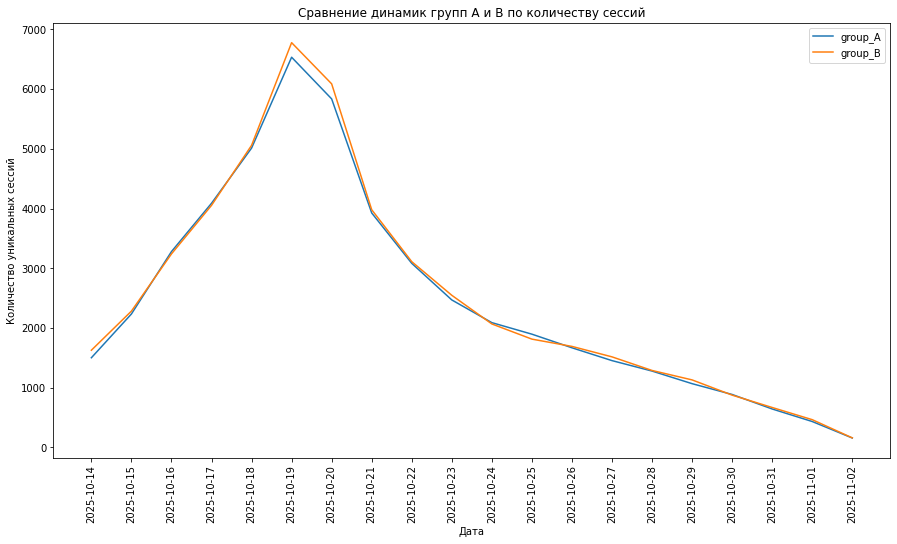

In [29]:
#Рассчитаем количество уникальных сессий по дням для обеих тестовых групп  и визуализируем результат
unique_session_test = (
    sessions_test
    .groupby(['test_group', 'session_date'])
    .agg({
        'session_id': 'nunique',
    })
    .reset_index()
)

x = unique_session_test.session_date.unique()
y_a = unique_session_test[unique_session_test.test_group=='A'].session_id
y_b = unique_session_test[unique_session_test.test_group=='B'].session_id

plt.figure(figsize=(15, 8))
plt.plot(x, y_a, label ='group_A')
plt.plot(x, y_b,label ='group_B')

plt.xlabel("Дата")
plt.ylabel("Количество уникальных сессий")
plt.legend()
plt.title('Сравнение динамик групп A и B по количеству сессий')
plt.xticks(rotation=90)
plt.show()

На первый взгляд, количество уникальных сессий в разбивке по дням сопоставимы для обеих групп.
Для проверки отсутствия статистически значимых различий в количестве уникальных дневных сессий в двух выборках выбераем статистический тест, позволяющий сделать вывод о равенстве средних двух выборок - t-тест. Нормальность выборочного среднего нам гарантирует большой объем наблюдений, независимость наблюдений мы проверяли на предыдущем шаге.  А применение t-теста Уэлча не требует проверки на равенство дисперсий.
Зафиксируем уровень значимости для проверки гипотезы на уровне 5%. И проверим обе выборки на равенство среднего количество сессий в двух выбрках. Нулевая гипотеза - "среднее количество уникальных сессий в день в выборках  равны", альнернативная гипотеза - "среднее количество уникальных сессий в день в выборках имеет статистически значимое отличие".

In [30]:
metric_a = unique_session_test[unique_session_test.test_group=='A'].session_id
metric_b = unique_session_test[unique_session_test.test_group=='B'].session_id 

alpha = 0.05 ## уровень значимости для проверки гипотезы о равенстве выборочных средних

stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    equal_var=False,
    alternative='two-sided' 
) 

if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Количество уникальных дневных сессий в двух выборках не имеет статистически значимого отличия')
else:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Количество уникальных дневных сессий в двух выборках различно')

p-value теста Уэлча =0.94
Количество уникальных дневных сессий в двух выборках не имеет статистически значимого отличия


С помощью t-тест мы подтвердили, что количество уникальных дневных сессий в двух выборках не имеет статистически значимого различия, а значит группы A и B сопоставимы и тест проведен корректно. Можем  приступать к анализу ключевых продуктовых метрик.

#### 4.3. Сравнение доли успешных сессий

Теперь можно переходить к анализу ключевой метрики — доли успешных сессий.

Рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе.

In [31]:
#рассчитаем долю успешных сессий для выборок A и B, и найдем разницу между ними
good_a = sessions_test[sessions_test['test_group']=='A']['good_session'].mean()
good_b = sessions_test[sessions_test['test_group']=='B']['good_session'].mean()
print(f'Доля успешных сессий в группе В составила {round(good_b, 3)}, в группе А - {round(good_a, 3)}, разница в пользу тестовой группы {round(good_b - good_a, 3)}')

Доля успешных сессий в группе В составила 0.318, в группе А - 0.308, разница в пользу тестовой группы 0.011


Доля успешных сессий а группе В на протяжении периода тестирования оказалась выше на 1.1%. Это может говорить о том, что новый алгоритм рекомендаций действительно дал положительный результат, и интерес пользователей к приложению вырос. Однако, чтобы сделать окончательный вывод, проверим является ли этот результат статистически значимым.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

Мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо проверить является ли это изменение статистически значимым.

Для проверки статистической значимости полученного  резульата будем использовать  Z-тест пропорций.
Проверим достаточный размер каждой из выборок для данного теста

In [32]:
#Проверим достаточный размер каждой из выборок для данного теста
n_a = sessions_test[sessions_test.test_group=='A'].shape[0]## размер выбороки A
n_b = sessions_test[sessions_test.test_group=='B'].shape[0]## размер выбороки B
m_a = sessions_test[(sessions_test.test_group=='A')&(sessions_test.good_session==1)].shape[0] # количество успехов в группе A
m_b = sessions_test[(sessions_test.test_group=='B')&(sessions_test.good_session==1)].shape[0] # количество успехов в группе B

p_a, p_b = m_a/n_a, m_b/n_b # рассчитываем доли успехов для каждой группы: A и B

print(f'n_a={n_a}, n_b={n_b}')

print(f'm_a={m_a}, m_b={m_b}')

print(f'p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=49551, n_b=50454
m_a=15248, m_b=16059
p_a=0.3077233557344958, p_b=0.31828992745867524
Предпосылка о достаточном количестве данных выполняется!


Предпосылки для проведения теста соблюдены: независимость данных и достаточный размер каждой из выборок.

Сформулируем нулевую гипотезу: "Доли успешных сессий в группах А и В равны." H0:pA = pB. 
Альтернативная гипотеза: "Доля успешных сессий в группе В выше, чем в группе А." H1:pA < pB

Основная метрика для проверки этой гипотезы — доля успешных сессий (с 4 и более просмотренными страницами).

Уровень статистической значимости  0.05.

In [34]:
#Импортируем тест
from statsmodels.stats.proportion import proportions_ztest
alpha = 0.05 

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения!


Нулевая гипотеза не подтвердилась, а значит мы можем говорить о том, что доля успешных сессий в тествойгрупе действительно выше,чем в контрольной.
Таким образом,  мы подтвердили статистическую значимость полученного резульата с помощью Z-тест пропорций, и теперь можем в дальнейшем отталкиваться от того, что новый алгоритм рекомендаций действительно привел к увеличению просматриваемых страниц, а значит контент для пользователей стал интереснее.

[*К содержанию*](#intro) 

<a id='5'></a>
### 5. Вывод по результатам A/B-эксперимента

В проекте был проведен анализ результатов А/В тестирования для развлекательного приложеня.

В ходе исследования было проведено ознакомление с историческими данными на временном провежутке от 11 августа 2025г до 23 сентября 2025г. Проанализирована динамика количества уникальных пользователей в день, а также зарегистрированных пользователй в день и их доля. Также было проанализировано количество просматриваемых страниц за одну сессию, чем выше этот показатель, тем выше заинтересованность пользователя. 
В качестве ключевой метрики для проведения тестирования была выбрана доля сессий, количество прсомотров страниц в которой 4 и более.

Далее был рассчитан необходимый для эксперимента размер выбоки. Для расчета были использованы следующие параметры:
- уровень значимости 0.05,
- вероятность ошибки второго рода  0.2,
- минимальный детектируемый эффект, или MDE,  3%. 
Необходимый размер выборки составил 17441 пользователей для каждой группы.
При данном размере выборки минимально необходимая длительность A/B-теста при рассчитанном уровене трафика в 9907 пользователей в день составил 4 дня.

На следующем этапе мы проводили мониторинг А/В тестирования.
Длительность теста  составила 20 дней, а количество уникальных пользователей  в первый день тестирвоания в группах А и В составило	соответсвенно 1477 и 1466 человек.
Мы убедились, что:
- процентная разница в количестве пользователей в группах A и B составляет менее 1%, а значит группы сопоставимы по размеру;
- группы независимы, никто из пользователей не попал в обе группы одновременно;
- пользователи в группах равномерно распределены по типам устройства и регионам,
- количество уникальных дневных сессий в двух выборках сопоставимо и не имеет статистически значимых различий (для этого был применен t-тест к данным эксперимента).

В результате анализа результатов проведенного тестирования, было установлено, что доля успешных сессий в тестовой группе оказалась выше, чем в контрольной группе, на 1.06%. С помощью Z-теста пропорций мы убедились, что данное изменение является для нас статистически значимым. Рассчитанный pvalue  составил 0.00016, что значительно ниже установленного уровня значимости в 5%.

**Основные выводы:**
Результаты A/B-тестирования, которое было проведено корректно, показали, что новый алгоритм рекомендаций, который должен показывать более интересный контент для каждого пользователя, дал положительные результаты. Доля успешных сессий в тестовой группе оказалась выше, чем в контрольной группе, на 1.1%. Доли составили соответсвенно в группе В 32%, в группе А 31%. 
Данный положительный  результат является статистически значимым, а значит новвоведение рекомендовано к внедрению.

[*К содержанию*](#intro) 